# Comparando um modelo de predição SARIMA com o FacebookProphet

### O banco de dados usado para a análise é 'AirPassengers'

### Os dados clássicos da companhia aérea Box & Jenkins. Totais mensais de passageiros de companhias aéreas internacionais, 1949 a 1960.

#### Fonte: Box, G. E. P., Jenkins, G. M. and Reinsel, G. C. (1976) Time Series Analysis, Forecasting and Control. Third Edition. Holden-Day. Series G.

#### Pacotes necessários

In [2]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt
from math import sin
from math import radians
from matplotlib import pyplot
import statsmodels.api as sm
from statsmodels.api import OLS
import pmdarima as pm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Lendo os dados
df = pd.read_excel (r'AirPassengers.xlsx')

### Primeiro, Vamos fazer a predição usando o modelo Prophet do Facebook

In [5]:
#df = df.set_index('Month')
#df.index

In [6]:
#separando os dados em treino e teste. Serão 12 meses para os testes
splitpoint=len(df)-12
dataset=df[0:splitpoint]
validation=df[splitpoint:]

#### Detalhe importante: Para o Prophet realizar as análises, é necessário que os dados referente às datas seja nomeado de 'ds' e os dados números a serem previsto sejam nomeados de 'y'

In [7]:
dataframe = pd.DataFrame({'ds':dataset.iloc[:,0],'y':dataset.iloc[:,1]})

In [8]:
dataframe.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


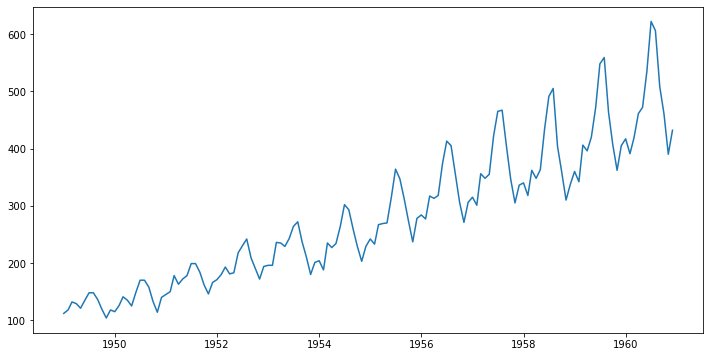

In [57]:
#Vizualizando os dados
df=pd.read_excel (r'AirPassengers.xlsx')
df['Month']=pd.to_datetime(df['Month'])
df=df.set_index('Month')
plt.subplots(1,figsize=(12,6))
plt.plot(df['Passengers'])
df=pd.read_excel (r'AirPassengers.xlsx')

## Parâmetros escolhidos

### seasonality_mode='multiplicative' (Os dados tem uma tendência e uma sazonalidade anual evidente)
### yearly_seasonality=True (Os dados são mensais e existe uma sazonalidade anual evidente)

In [16]:
model=Prophet(growth='linear',seasonality_mode='multiplicative',yearly_seasonality=True,weekly_seasonality=False,daily_seasonality=False)

In [18]:
model.fit(dataframe)

In [19]:
#gerando dados futuros
futuro=model.make_future_dataframe(periods=12,freq='M')

In [63]:
saida=model.predict(futuro)

In [64]:
saida_previsao=saida[{'yhat'}].tail(12)
saida_previsao

,yhat
132,404.486493
133,406.821810
134,442.202987
135,430.809478
136,450.453747
137,506.281874
138,585.911496
139,583.036134
140,488.397859
141,428.435930


### Usaremos a raiz quadrada do erro quadrático médio como métrica para avaliar o modelo

In [65]:
rmse=sqrt(mean_squared_error(validation.iloc[:,1],saida_limpa.iloc[:,0]))

In [66]:
print('A raiz quadrada do erro quadrático médio foi: %.3f' % rmse)

A raiz quadrada do erro quadrático médio foi: 23.626


### Vendo no gráfico a comparação entre os dados reais e os dados previstos

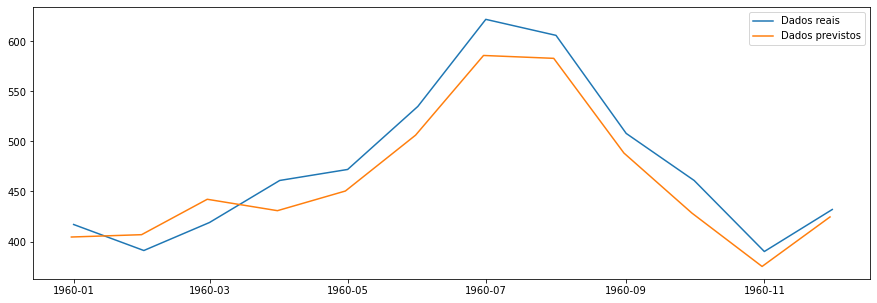

In [188]:
df=pd.read_excel (r'AirPassengers.xlsx')
df['Month']=pd.to_datetime(df['Month'])
df=df.set_index('Month')
saida['ds']=pd.to_datetime(saida['ds'])
saida=saida.set_index('ds')
plt.subplots(1,figsize=(15,5))
plt.plot(df['Passengers'][132:144],label = 'Dados reais')
plt.plot(saida['yhat'][132:144],label = 'Dados previstos')
plt.legend()
df=pd.read_excel (r'AirPassengers.xlsx')

### Analisando os resíduos do modelo

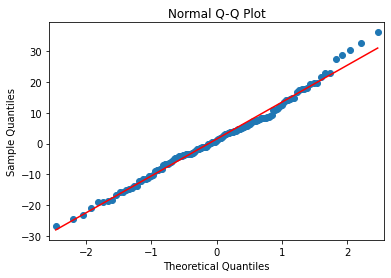

In [118]:
saida=model.predict(futuro)
ymdl=saida[{'ds','yhat','yhat_lower','yhat_upper'}]
residuos=df['Passengers']-ymdl['yhat']
fig = sm.qqplot(residuos,line='r')
plt.title('Normal Q-Q Plot')
plt.show()

### pelo qqplot temos uma noção de que os resíduos do modelo são normais

### Aplicacao do modelo sarima

In [119]:
df = pd.read_excel (r'AirPassengers.xlsx')
#df['Month']=pd.to_datetime(df['Month'])
#df['Month']=df.set_index('Month')

In [121]:
#definindo os dados de treino e teste
df_train=df[:len(df)-12]
df_test=df[(len(df)-12):]

### Para a aplicação de um modelo SARIMA é necessário que os dados temporais sejam estacionários.
### Estacionariedade pode ser definida em termos matemáticos precisos, mas para os nossos propósitos queremos dizer uma série parecida com um plano liso, sem tendência, variância constante no decorrer do tempo, uma estrutura de autocorrelação constante no decorrer do tempo e nenhuma flutuação periódica (sazonalidada).

In [148]:
#teste de estacionariedade Augmented Dickey-Fuller (ADF)
#H0: os dados não são estacionários
#H1: os dados são estacionários
result=adfuller(df_train['Passengers'])

print('ADF Statistic: %f' % result[0])
print('p-value %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.888027
p-value 0.992932
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


### pelo p valor > 0.05 temos que esses dados não são estacionários

In [149]:
#tomando uma diferenca simples
df1=df.diff()
df1=df1.dropna()

In [150]:
df_train=df1[:len(df1)-12]
df_test=df1[(len(df1)-12):]

In [151]:
#teste de estacionariedade novamente
result=adfuller(df_train['Passengers'])
print('ADF Statistic: %f' % result[0])
print('p-value %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.402920
p-value 0.140914
Critical Values:
	1%: -3.488
	5%: -2.887
	10%: -2.580


### Ainda temos os dados como não estacionários

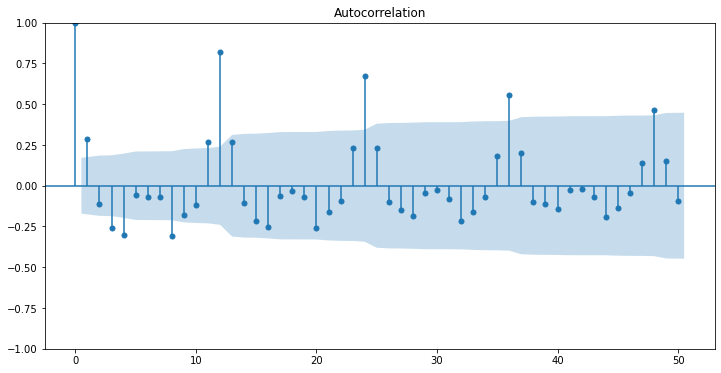

In [160]:
#grafico ACF indica que os dados ainda nao sao estacionarios. Temos uma sazonalidade anual.
fig,ax=plt.subplots(1,figsize=(12,6))
ax=plot_acf(df_train['Passengers'],ax=ax,lags=50)

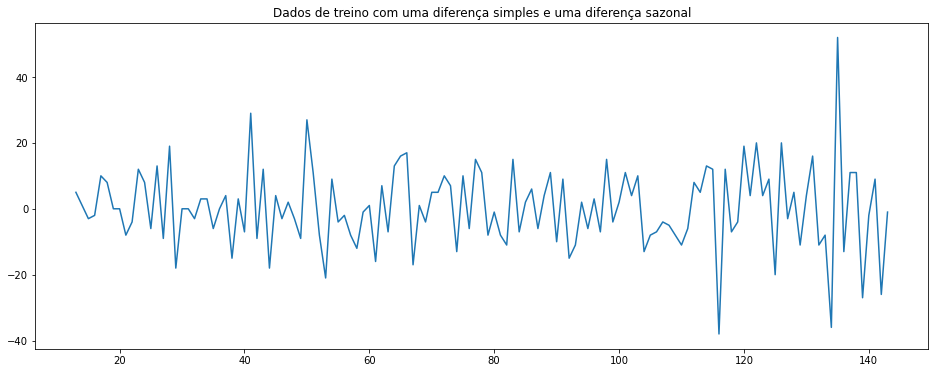

In [161]:
#tomando uma diferenca sazonal de 12 meses: lag=12
df2 = df1 - df1.shift(12)
df2 = df2.dropna()
plt.subplots(1,figsize=(16,6))
df2['Passengers'].plot()
plt.title('Dados de treino com uma diferença simples e uma diferença sazonal')
plt.show()

In [162]:
df_train=df2[:len(df1)-12]
df_test=df2[(len(df1)-12):]

In [163]:
#Agora o teste nos deu a informaçao que os dados são estacionarios
result=adfuller(df_train['Passengers'])
print('ADF Statistic: %f' % result[0])
print('p-value %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.595618
p-value 0.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


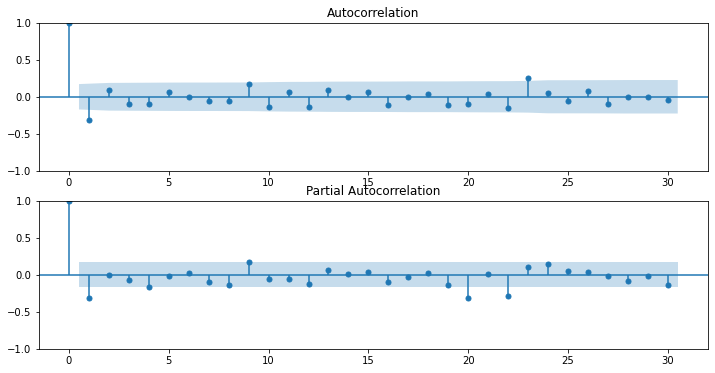

In [164]:
#O grafico ACF e PACF indicam que os dados agora são estacionários
fig,ax=plt.subplots(2,figsize=(12,6))
ax[0]=plot_acf(df_train['Passengers'],ax=ax[0],lags=30)
ax[1]=plot_pacf(df_train['Passengers'],ax=ax[1],lags=30)

### Aplicando o modelo SARIMA

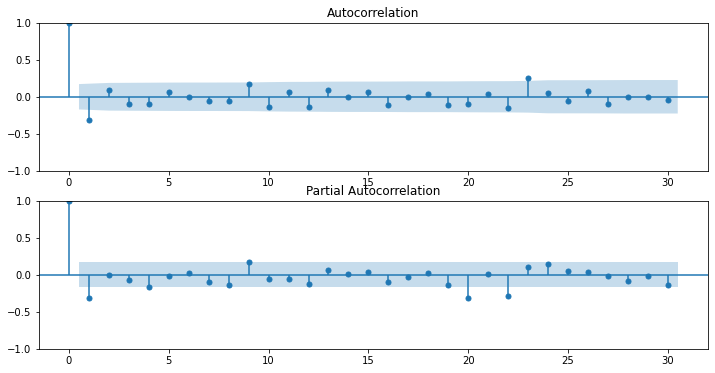

In [166]:
#gráfico acf e pacf irá ajudar a escolher os parâmetros do modelo
#sabemos que d=1 e D=1
fig,ax=plt.subplots(2,figsize=(12,6))
ax[0]=plot_acf(df_train['Passengers'],ax=ax[0],lags=30)
ax[1]=plot_pacf(df_train['Passengers'],ax=ax[1],lags=30)

In [167]:
#demais parâmetros:
#p=1: ACF decaindo rapidamente para zero e PACF com pequena "quebra" no lag 1
#q=0 ou q=1: ACF com suposta "quebra" no lag 1
# P = 0: ACF e PACF sem autocorelações nos lags sazonais
# Q = 0: ACF e PACF sem autocorelações nos lags sazonais 

In [174]:
#modelo SARIMA(1,1,0)x(0,1,0)
df_train=df[:len(df)-12]
df_test=df[(len(df)-12):]
df_train=df_train.set_index('Month')
modelo1 = sm.tsa.statespace.SARIMAX(df_train,order=(1, 1, 0),seasonal_order=(0, 1, 0, 12),enforce_stationarity=True,enforce_invertibility=True)
modelo1_aic = modelo1.fit()
print(modelo1_aic.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  132
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -447.951
Date:                            Fri, 12 Nov 2021   AIC                            899.902
Time:                                    17:48:55   BIC                            905.460
Sample:                                01-01-1949   HQIC                           902.159
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2431      0.090     -2.697      0.007      -0.420      -0.066
sigma2       108.8757     13.306   

In [176]:
#modelo SARIMA(1,1,1)x(0,1,0)
df_train=df[:len(df)-12]
df_test=df[(len(df)-12):]
df_train=df_train.set_index('Month')
modelo2 = sm.tsa.statespace.SARIMAX(df_train,order=(1, 1, 1),seasonal_order=(0, 1, 0, 12),enforce_stationarity=True,enforce_invertibility=True)
modelo2_aic = modelo2.fit()
print(modelo2_aic.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          Passengers   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -447.486
Date:                             Fri, 12 Nov 2021   AIC                            900.971
Time:                                     17:49:05   BIC                            909.309
Sample:                                 01-01-1949   HQIC                           904.357
                                      - 12-01-1959                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5536      0.304     -1.818      0.069      -1.150       0.043
ma.L1          0.3327      

### Calculando a raiz do erro quadrático médio para os dois modelos. O que tiver o menor REQM será o escolhido para comparação com o Prophet

In [183]:
forecast1 = modelo1_aic.get_prediction(start=132,end=143,dynamic=False)
predictions1=forecast1.predicted_mean
actual = df_test['Passengers']

rmse1=sqrt(mean_squared_error(actual,predictions1))
print('A raiz quadrada do erro quadrático médio para o modelo SARIMA(1,1,0)x(0,1,0) é {}'.format(rmse1))

A raiz quadrada do erro quadrático médio para o modelo SARIMA(1,1,0)x(0,1,0) é 23.931673206170778


In [184]:
forecast2 = modelo2_aic.get_prediction(start=132,end=143,dynamic=False)
predictions2=forecast2.predicted_mean
actual = df_test['Passengers']

rmse2=sqrt(mean_squared_error(actual,predictions2))
print('A raiz quadrada do erro quadrático médio para o modelo SARIMA(1,1,1)x(0,1,0) é {}'.format(rmse2))

A raiz quadrada do erro quadrático médio para o modelo SARIMA(1,1,1)x(0,1,0) é 24.809438105227304


### Usaremos o modelo SARIMA(1,1,0)x(0,1,0)

### Análise dos resíduos para o modelo 1

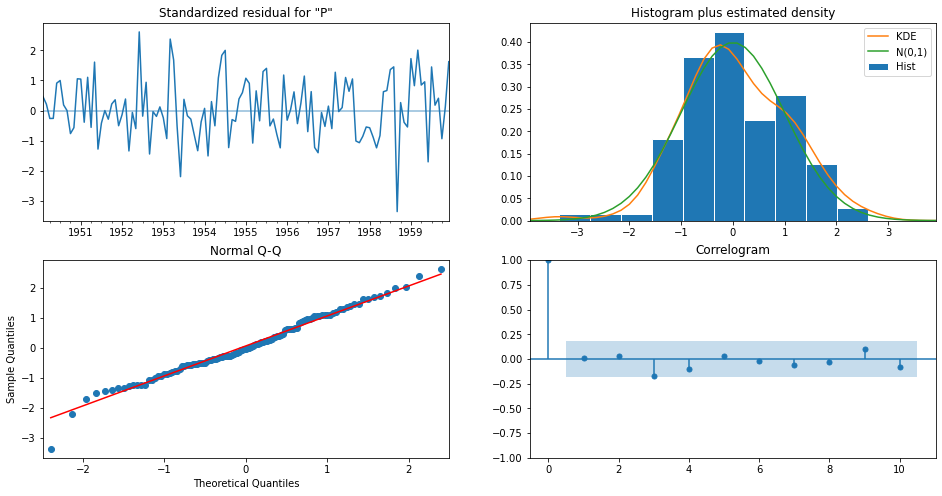

In [185]:
modelo1_aic.plot_diagnostics(figsize=(16,8))
plt.show()

### Ao que tudo indica os resíduos são normais

### Vendo no gráfico a comparação entre os dados reais e os dados previstos

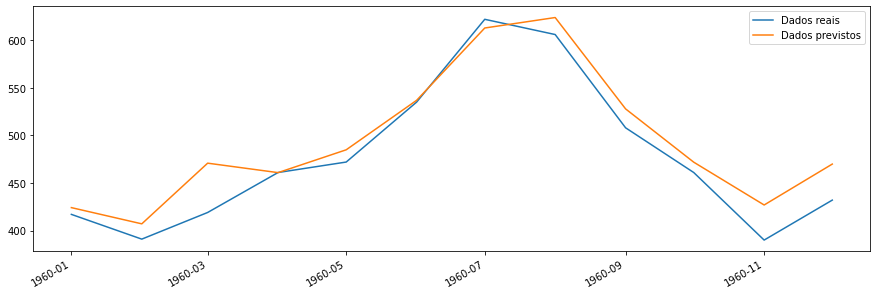

In [187]:
df = pd.read_excel (r'AirPassengers.xlsx')
forecast = modelo_aic.get_forecast(steps=12)
#previsoes e intervalo de confianca

predictions=forecast.predicted_mean
#ci=forecast.conf_int()

#observando o gráfico
df['Month']=pd.to_datetime(df['Month'])
df=df.set_index('Month')
plt.subplots(1,figsize=(15,5))
fig = plt.plot(df['Passengers'][132:144],label = 'Dados reais')

#plot predito

predictions.plot(label='Dados previstos')
plt.legend()
df = pd.read_excel (r'AirPassengers.xlsx')

# Conclusão

### O modelo Prophet do Facebook e o SARIMA se saíram muito bem na previsão de 1 ano dos dados, por mês.
### Apesar disso, o Prophet obteve uma raiz do erro quadrático médio menor do que o modelo SARIMA
### Se não fosse a escolha correta dos parâmetros para que o Prophet aprendesse bem sobre os dados, o modelo SARIMA se sairia melhor. 
### Talvez se a análise fosse aplicada para dados com mais observações a diferença entre os dois modelos fosse mais evidente